# **Overview**

We want to predict the price of houses in `Buenos-Aires`, `Capital Federal` district which are less than `300 000` USD.


## **GOALS:**
- Build a model to predict house price.
- Evaluate all features in the dataset for use in our model.
- Create a mini-deployment of our model.

      1. Using `make_prediction` function.
      2. Interactive dashboard using Jupyter Widgets.

# **Prepare Data**

In [1]:
# Supress warnings
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

import pandas as pd # data wrangling
import seaborn as sns # data visualization
import plotly.express as px
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# For handling multiple files
from glob import glob

# for cat features
from category_encoders import OneHotEncoder

# For interactive dashboard
from ipywidgets import Dropdown, FloatSlider, IntSlider, interact

from sklearn.impute import SimpleImputer # Handling missing values
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline

# Disable the SettingWithCopyWarning
pd.options.mode.chained_assignment = None  # default='warn'

## **Import** ✅

Since there are **5** similar **CSV** files from the source, we import a single **CSV** file from available data to get understanding of the features in our dataset.

In [2]:
# Load data
df = pd.read_csv("./data/buenos-aires-real-estate-1.csv")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8606 entries, 0 to 8605
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   8606 non-null   object 
 1   property_type               8606 non-null   object 
 2   place_with_parent_names     8606 non-null   object 
 3   lat-lon                     6936 non-null   object 
 4   price                       7590 non-null   float64
 5   currency                    7590 non-null   object 
 6   price_aprox_local_currency  7590 non-null   float64
 7   price_aprox_usd             7590 non-null   float64
 8   surface_total_in_m2         5946 non-null   float64
 9   surface_covered_in_m2       7268 non-null   float64
 10  price_usd_per_m2            4895 non-null   float64
 11  price_per_m2                6520 non-null   float64
 12  floor                       1259 non-null   float64
 13  rooms                       4752 

,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
0,sell,apartment,|Argentina|Capital Federal|Villa Crespo|,"-34.6047834183,-58.4586812499",180000.0,USD,2729232.0,180000.0,120.0,110.0,1500.000000,1636.363636,NaN,4.0,NaN,http://villa-crespo.properati.com.ar/12egq_ven...
1,sell,house,|Argentina|Bs.As. G.B.A. Zona Oeste|La Matanza...,NaN,250000.0,USD,3790600.0,250000.0,117.0,120.0,2136.752137,2083.333333,NaN,4.0,NaN,http://ramos-mejia.properati.com.ar/s7pd_venta...
2,sell,house,|Argentina|Bs.As. G.B.A. Zona Oeste|Morón|Cast...,"-34.6497002,-58.658073",410000.0,USD,6216584.0,410000.0,410.0,220.0,1000.000000,1863.636364,NaN,NaN,NaN,http://castelar-moron.properati.com.ar/11vgn_v...
3,sell,house,|Argentina|Bs.As. G.B.A. Zona Oeste|Tres de Fe...,"-34.5957086,-58.5669503",180000.0,USD,2729232.0,180000.0,200.0,135.0,900.000000,1333.333333,NaN,5.0,NaN,http://tres-de-febrero.properati.com.ar/7f7u_v...
4,sell,apartment,|Argentina|Capital Federal|Chacarita|,"-34.5846508988,-58.4546932614",129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...


The dataset has 16 columns, with 7 categorical and 9 numeric columns.

## **Explore**

### **1. Target variable**

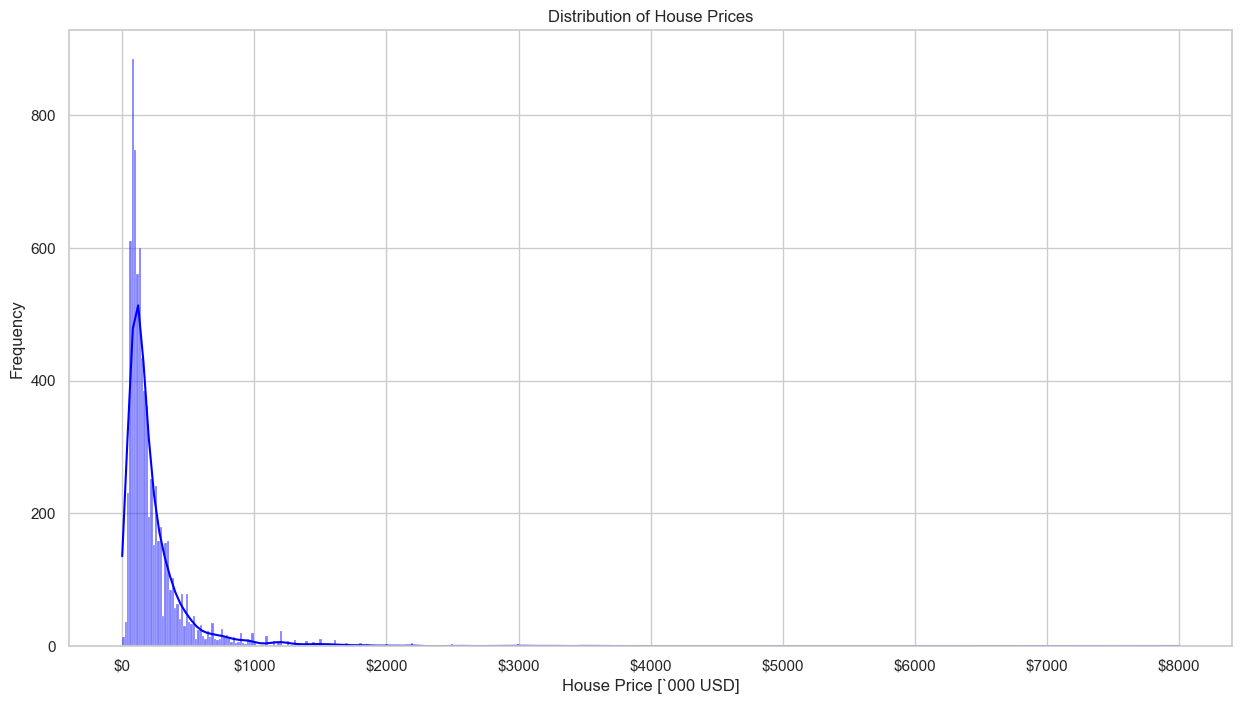

In [3]:
# Create a distribution plot using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(15, 8))
sns.histplot(df["price_aprox_usd"], kde=True, color="blue")

# Adding labels and title
plt.xlabel("House Price [`000 USD]")
plt.ylabel("Frequency")
plt.title("Distribution of House Prices")

# Format x-axis labels to display prices in "$100,000" format (BONUS)
def price_formatter(x, pos):
    return f"${int(x/1000):}"

ax = plt.gca()
ax.xaxis.set_major_formatter(mticker.FuncFormatter(price_formatter))

plt.show()

In [4]:
# Compute max house price
max_price = max(df.price_aprox_usd)
print(f"Maximum house price: ${max_price:.2f}")

Maximum house price: $8000000.00


Most of the properties for sale in **Buenos Aires** that I found on [realtor.com2](https://www.realtor.com/international/ar/) and [realigro.com3](https://argentina.realigro.com/for-sale/property/) were priced between `100,000 USD` and `1 million USD`, depending on the location, size and condition of the property. There were some luxury properties that exceeded `1 million USD`, but none that reached `8 million USD`. Based on the distribution displayed above, we will consider houses with a price less than `300 000 USD`.

#### 1. Filtering using boolean mask ✅

Considering the goal of this project, we filter our dataset to include only `houses` from `Capital Federal` with a price less than `$300 000` using **boolean mask**.

In [5]:
# Subset data: houses in "Capital Federal", less than 300,000
mask_cap= df["place_with_parent_names"].str.contains("Capital Federal")
mask_hse = df["property_type"] == "house"
mask_price = df["price_aprox_usd"] < 300_000

# filter data
df2 = df[mask_cap & mask_hse & mask_price]
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 78 entries, 184 to 8600
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   78 non-null     object 
 1   property_type               78 non-null     object 
 2   place_with_parent_names     78 non-null     object 
 3   lat-lon                     76 non-null     object 
 4   price                       78 non-null     float64
 5   currency                    78 non-null     object 
 6   price_aprox_local_currency  78 non-null     float64
 7   price_aprox_usd             78 non-null     float64
 8   surface_total_in_m2         51 non-null     float64
 9   surface_covered_in_m2       65 non-null     float64
 10  price_usd_per_m2            48 non-null     float64
 11  price_per_m2                65 non-null     float64
 12  floor                       1 non-null      float64
 13  rooms                       43 non-nul

#### 2. Remove Outliers

Text(0.5, 1.0, 'Boxplot: Surface Area Covered by the Building')

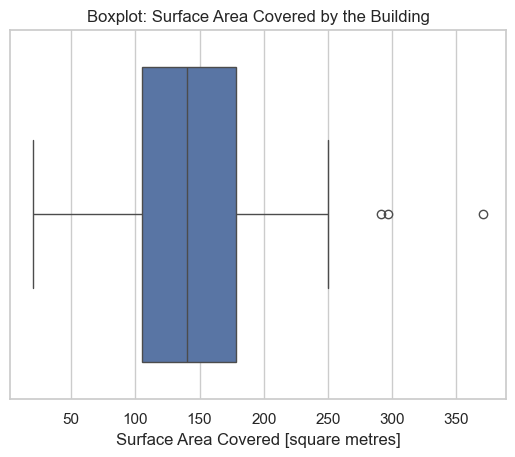

In [52]:

sns.boxplot(df2, x="surface_covered_in_m2", orient="h")
plt.xlabel("Surface Area Covered [square metres]")
plt.title("Boxplot: Surface Area Covered by the Building")

In [7]:
# Remove outliers
low, high = df2["surface_covered_in_m2"].quantile([0.1, 0.9])

# subsetting based on quantiles
mask_area = df2["surface_covered_in_m2"].between(low, high)
df3 = df2[mask_area]
df3.head(4)

,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
184,sell,house,|Argentina|Capital Federal|Flores|,"-34.6374837,-58.4601452",239000.0,USD,3623813.6,239000.0,150.0,144.0,1593.333333,1659.722222,NaN,NaN,NaN,http://flores.properati.com.ar/12pgl_venta_cas...
195,sell,house,|Argentina|Capital Federal|Boca|,"-34.628398,-58.3619026",240000.0,USD,3638976.0,240000.0,146.0,135.0,1643.835616,1777.777778,NaN,5.0,NaN,http://boca.properati.com.ar/10t85_venta_casa_...
439,sell,house,|Argentina|Capital Federal|Villa Lugano|,"-34.6632794,-58.4795435",250000.0,USD,3790600.0,250000.0,230.0,190.0,1086.956522,1315.789474,NaN,4.0,NaN,http://villa-lugano.properati.com.ar/yd6n_vent...
590,sell,house,|Argentina|Capital Federal|Coghlan|,"-34.5603249,-58.4709941",270000.0,USD,4093848.0,270000.0,249.0,164.0,1084.337349,1646.341463,NaN,5.0,NaN,http://coghlan.properati.com.ar/105vq_venta_ca...


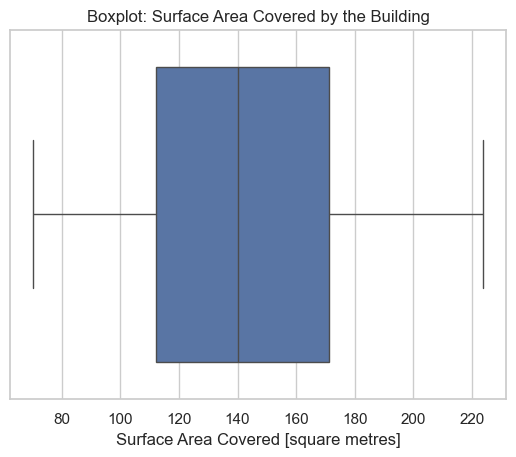

In [8]:
sns.boxplot(df3, x="surface_covered_in_m2", orient="h")
plt.xlabel("Surface Area Covered [square metres]")
plt.title("Boxplot: Surface Area Covered by the Building")

#### 3. String split for engineering new features

In [9]:
# Split "lat-lon" column
df3[["lat", "lon"]]  = df3["lat-lon"].str.split(",", expand=True).astype(float)
df3.drop(columns="lat-lon", inplace=True)
print(df3.info())

<class 'pandas.core.frame.DataFrame'>
Index: 52 entries, 184 to 8600
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   52 non-null     object 
 1   property_type               52 non-null     object 
 2   place_with_parent_names     52 non-null     object 
 3   price                       52 non-null     float64
 4   currency                    52 non-null     object 
 5   price_aprox_local_currency  52 non-null     float64
 6   price_aprox_usd             52 non-null     float64
 7   surface_total_in_m2         37 non-null     float64
 8   surface_covered_in_m2       52 non-null     float64
 9   price_usd_per_m2            34 non-null     float64
 10  price_per_m2                52 non-null     float64
 11  floor                       0 non-null      float64
 12  rooms                       34 non-null     float64
 13  expenses                    0 non-null

In [10]:
# Get place name
df3["neighborhood"] = df3["place_with_parent_names"].str.split("|", expand=True)[3]
df3.drop(columns="place_with_parent_names", inplace=True)
df3.head()

,operation,property_type,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url,lat,lon,neighborhood
184,sell,house,239000.0,USD,3623813.6,239000.0,150.0,144.0,1593.333333,1659.722222,NaN,NaN,NaN,http://flores.properati.com.ar/12pgl_venta_cas...,-34.637484,-58.460145,Flores
195,sell,house,240000.0,USD,3638976.0,240000.0,146.0,135.0,1643.835616,1777.777778,NaN,5.0,NaN,http://boca.properati.com.ar/10t85_venta_casa_...,-34.628398,-58.361903,Boca
439,sell,house,250000.0,USD,3790600.0,250000.0,230.0,190.0,1086.956522,1315.789474,NaN,4.0,NaN,http://villa-lugano.properati.com.ar/yd6n_vent...,-34.663279,-58.479543,Villa Lugano
590,sell,house,270000.0,USD,4093848.0,270000.0,249.0,164.0,1084.337349,1646.341463,NaN,5.0,NaN,http://coghlan.properati.com.ar/105vq_venta_ca...,-34.560325,-58.470994,Coghlan
812,sell,house,189000.0,USD,2865693.6,189000.0,113.0,80.0,1672.566372,2362.500000,NaN,NaN,NaN,http://flores.properati.com.ar/1204o_venta_cas...,-34.637556,-58.463511,Flores


#### 4. Missing values

In [11]:
# checking missing values
df3.isnull().sum()/len(df3)*100

operation                       0.000000
property_type                   0.000000
price                           0.000000
currency                        0.000000
price_aprox_local_currency      0.000000
price_aprox_usd                 0.000000
surface_total_in_m2            28.846154
surface_covered_in_m2           0.000000
price_usd_per_m2               34.615385
price_per_m2                    0.000000
floor                         100.000000
rooms                          34.615385
expenses                      100.000000
properati_url                   0.000000
lat                             0.000000
lon                             0.000000
neighborhood                    0.000000
dtype: float64

In [12]:
# Drop features with high null values
df3.drop(columns=["floor", "expenses"], inplace=True)

#### 5. Cardinality of features

In [13]:
# checking the cardinality of features
feature_cardinality = df3.select_dtypes("object").nunique()
feature_cardinality

operation         1
property_type     1
currency          1
properati_url    52
neighborhood     24
dtype: int64

In [14]:
# Drop low- and high-cardinality categorical features
df3.drop(columns=["property_type","operation","currency","properati_url"], inplace=True)

All features with one unique value are dropped as they have no contribution to model performance. Features with high cardinality were also dropped as they will increase the dimensionality of features in our model.

#### 6. Leaky features

This refers to features (columns) in a dataset that contain information about the target variable (i.e., the variable being predicted), which are not available at the time of prediction.

Including these leaky features in a predictive model can lead to overfitting and unrealistically high performance on the training data. This is because the model is able to directly access information about the target variable that it wouldn't have access to in a real-world scenario, where the target variable is unknown at the time of prediction

In [15]:
df3.head()

,price,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,rooms,lat,lon,neighborhood
184,239000.0,3623813.6,239000.0,150.0,144.0,1593.333333,1659.722222,NaN,-34.637484,-58.460145,Flores
195,240000.0,3638976.0,240000.0,146.0,135.0,1643.835616,1777.777778,5.0,-34.628398,-58.361903,Boca
439,250000.0,3790600.0,250000.0,230.0,190.0,1086.956522,1315.789474,4.0,-34.663279,-58.479543,Villa Lugano
590,270000.0,4093848.0,270000.0,249.0,164.0,1084.337349,1646.341463,5.0,-34.560325,-58.470994,Coghlan
812,189000.0,2865693.6,189000.0,113.0,80.0,1672.566372,2362.500000,NaN,-34.637556,-58.463511,Flores


In [16]:
# Drop leaky features
df3.drop(
    columns=
    ['price',
    'price_aprox_local_currency',
    'price_per_m2',
    'price_usd_per_m2'], 
    inplace=True
)
df3.head()

,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,rooms,lat,lon,neighborhood
184,239000.0,150.0,144.0,NaN,-34.637484,-58.460145,Flores
195,240000.0,146.0,135.0,5.0,-34.628398,-58.361903,Boca
439,250000.0,230.0,190.0,4.0,-34.663279,-58.479543,Villa Lugano
590,270000.0,249.0,164.0,5.0,-34.560325,-58.470994,Coghlan
812,189000.0,113.0,80.0,NaN,-34.637556,-58.463511,Flores


#### 7. High Collinearity

In [17]:
corr_df = df3.select_dtypes("number").corr()
corr_df

,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,rooms,lat,lon
price_aprox_usd,1.000000,0.037634,0.479536,0.145492,0.117994,-0.016904
surface_total_in_m2,0.037634,1.000000,0.251142,0.127402,0.071780,0.009936
surface_covered_in_m2,0.479536,0.251142,1.000000,0.447277,-0.306525,-0.130012
rooms,0.145492,0.127402,0.447277,1.000000,-0.017564,0.043489
lat,0.117994,0.071780,-0.306525,-0.017564,1.000000,0.154819
lon,-0.016904,0.009936,-0.130012,0.043489,0.154819,1.000000


In [18]:
fig = px.imshow(corr_df, color_continuous_scale='Spectral')
fig.update_layout(title='Heat Map: Correlation of Features', font=dict(size=12))
fig.show();

From the correlation matrix displayed, it is clearly indicated that there is high multicolinearity on `surface_covered_in_m2` against `rooms` and `surface_total_in_m2`. By looking at these 3 features, `surface_covered_in_m2` is more important than number of rooms and the total surface area and therefore we will drop `surface_total_in_m2` and `rooms`.

In [19]:
# Drop features with high collinearity
df3.drop(columns=['surface_total_in_m2','rooms'], inplace=True)
print(df3.info())
df3.head()

<class 'pandas.core.frame.DataFrame'>
Index: 52 entries, 184 to 8600
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        52 non-null     float64
 1   surface_covered_in_m2  52 non-null     float64
 2   lat                    52 non-null     float64
 3   lon                    52 non-null     float64
 4   neighborhood           52 non-null     object 
dtypes: float64(4), object(1)
memory usage: 2.4+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
184,239000.0,144.0,-34.637484,-58.460145,Flores
195,240000.0,135.0,-34.628398,-58.361903,Boca
439,250000.0,190.0,-34.663279,-58.479543,Villa Lugano
590,270000.0,164.0,-34.560325,-58.470994,Coghlan
812,189000.0,80.0,-34.637556,-58.463511,Flores


### Glob
The module `glob` is commonly used for searching files with specific extensions or names. It seeks to find all the pathnames matching a specified pattern.

In [20]:
files = glob("./data/buenos-aires-real-estate-*.csv")
files

['./data\\buenos-aires-real-estate-1.csv',
 './data\\buenos-aires-real-estate-2.csv',
 './data\\buenos-aires-real-estate-3.csv',
 './data\\buenos-aires-real-estate-4.csv',
 './data\\buenos-aires-real-estate-5.csv']

In [21]:
# printing file paths
for file in files:
    print(file)

./data\buenos-aires-real-estate-1.csv
./data\buenos-aires-real-estate-2.csv
./data\buenos-aires-real-estate-3.csv
./data\buenos-aires-real-estate-4.csv
./data\buenos-aires-real-estate-5.csv


In [22]:
# Alternative way to generate a list of dataframes
data_frames1 = []

for file in files:
    data_frames1.append(
        pd.read_csv(file)
    )

In [23]:
# prepare each file in the list and stores in frames list.
data_frames = [pd.read_csv(file) for file in files]

In [24]:
# checking the data type of each file in frames
for i in range(0,5):
    print(type(data_frames1[i]))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [25]:
# join the dataframes together
df = pd.concat(data_frames, ignore_index=True)
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43029 entries, 0 to 43028
Data columns (total 16 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   operation                   43029 non-null  object 
 1   property_type               43029 non-null  object 
 2   place_with_parent_names     43029 non-null  object 
 3   lat-lon                     34734 non-null  object 
 4   price                       38073 non-null  float64
 5   currency                    38072 non-null  object 
 6   price_aprox_local_currency  38073 non-null  float64
 7   price_aprox_usd             38073 non-null  float64
 8   surface_total_in_m2         29871 non-null  float64
 9   surface_covered_in_m2       36420 non-null  float64
 10  price_usd_per_m2            24449 non-null  float64
 11  price_per_m2                32642 non-null  float64
 12  floor                       6505 non-null   float64
 13  rooms                       238

,operation,property_type,place_with_parent_names,lat-lon,price,currency,price_aprox_local_currency,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,price_per_m2,floor,rooms,expenses,properati_url
0,sell,apartment,|Argentina|Capital Federal|Villa Crespo|,"-34.6047834183,-58.4586812499",180000.0,USD,2729232.0,180000.0,120.0,110.0,1500.000000,1636.363636,NaN,4.0,NaN,http://villa-crespo.properati.com.ar/12egq_ven...
1,sell,house,|Argentina|Bs.As. G.B.A. Zona Oeste|La Matanza...,NaN,250000.0,USD,3790600.0,250000.0,117.0,120.0,2136.752137,2083.333333,NaN,4.0,NaN,http://ramos-mejia.properati.com.ar/s7pd_venta...
2,sell,house,|Argentina|Bs.As. G.B.A. Zona Oeste|Morón|Cast...,"-34.6497002,-58.658073",410000.0,USD,6216584.0,410000.0,410.0,220.0,1000.000000,1863.636364,NaN,NaN,NaN,http://castelar-moron.properati.com.ar/11vgn_v...
3,sell,house,|Argentina|Bs.As. G.B.A. Zona Oeste|Tres de Fe...,"-34.5957086,-58.5669503",180000.0,USD,2729232.0,180000.0,200.0,135.0,900.000000,1333.333333,NaN,5.0,NaN,http://tres-de-febrero.properati.com.ar/7f7u_v...
4,sell,apartment,|Argentina|Capital Federal|Chacarita|,"-34.5846508988,-58.4546932614",129000.0,USD,1955949.6,129000.0,76.0,70.0,1697.368421,1842.857143,NaN,NaN,NaN,http://chacarita.properati.com.ar/10qlv_venta_...


In [26]:
df.to_csv("./data/joined_data.csv")

### Create `prepare_data()` function

In [27]:
# Creating a function to prepare data
def prepare_data(path):

    # read file paths and printout
    file_paths = glob(path)

    # List comprehension to read data from file paths
    dataframes = [pd.read_csv(file) for file in file_paths]

    # Concatenate the dataframes
    df = pd.concat(dataframes)

    # Subset data: apartment in "Capital Federal", less than 400,000
    mask_ba = df["place_with_parent_names"].str.contains("Capital Federal")
    mask_hse = df["property_type"] == "apartment"
    mask_price = df["price_aprox_usd"] < 400_000 # Target

    # filter dataset
    df = df[mask_ba & mask_hse & mask_price]

    # Subset data: Remove outliers for "surface_covered_in_m2"
    low, high = df["surface_covered_in_m2"].quantile([0.1, 0.9])
    mask_area = df["surface_covered_in_m2"].between(low, high)
    df = df[mask_area]

    # Split "lat-lon" column
    df[["lat", "lon"]] = df["lat-lon"].str.split(",", expand=True).astype(float)
    df.drop(columns = "lat-lon", inplace=True)

    # Get place name
    df["neighborhood"] = df["place_with_parent_names"].str.split("|", expand=True)[3]
    df.drop(columns="place_with_parent_names", inplace=True)

    # Drop features with high null counts
    df.drop(columns=["floor", "expenses"], inplace=True)

    # Drop low- and high-cardinality categorical features
    df.drop(columns=["property_type","operation","currency","properati_url"], inplace=True)

    # Drop leaky features
    df.drop(
        columns=['price',
                 'price_aprox_local_currency',
                 'price_per_m2',
                 'price_usd_per_m2'],
        inplace=True
        )

    # Drop features with high collinearity
    df.drop(columns=['surface_total_in_m2','rooms'], inplace=True)

    return df

### Import using a `prepare_data` function

In [28]:
prepared_df = prepare_data("./data/buenos-aires-real-estate-*.csv")
print(prepared_df.info())
prepared_df.to_csv('./data/prepared_df.csv')
prepared_df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 6507 entries, 4 to 8597
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   price_aprox_usd        6507 non-null   float64
 1   surface_covered_in_m2  6507 non-null   float64
 2   lat                    6247 non-null   float64
 3   lon                    6247 non-null   float64
 4   neighborhood           6507 non-null   object 
dtypes: float64(4), object(1)
memory usage: 305.0+ KB
None


,price_aprox_usd,surface_covered_in_m2,lat,lon,neighborhood
4,129000.0,70.0,-34.584651,-58.454693,Chacarita
9,87000.0,42.0,-34.638979,-58.500115,Villa Luro
29,118000.0,54.0,-34.615847,-58.459957,Caballito
40,57000.0,42.0,-34.625222,-58.382382,Constitución
41,90000.0,50.0,-34.610610,-58.412511,Once


__Location features:__ We can assess house prices by location on a map.

In [29]:
import plotly.express as px

fig = px.scatter_mapbox(
    prepared_df,  # Our DataFrame
    lat='lat',
    lon="lon",
    width=1000,  # Width of map
    height=800,  # Height of map
    color="price_aprox_usd",
    hover_data=["price_aprox_usd"],  # Display price when hovering mouse over house
)

fig.update_layout(mapbox_style="open-street-map")

fig.show()

## **Split**

In [30]:
import numpy as np

# Separate features from the target.
target = "price_aprox_usd"
features =["lat","lon","surface_covered_in_m2","neighborhood"]
X = prepared_df[features] # dataframe
y = prepared_df[target] # series

In [31]:
print(y.head())

4     129000.0
9      87000.0
29    118000.0
40     57000.0
41     90000.0
Name: price_aprox_usd, dtype: float64


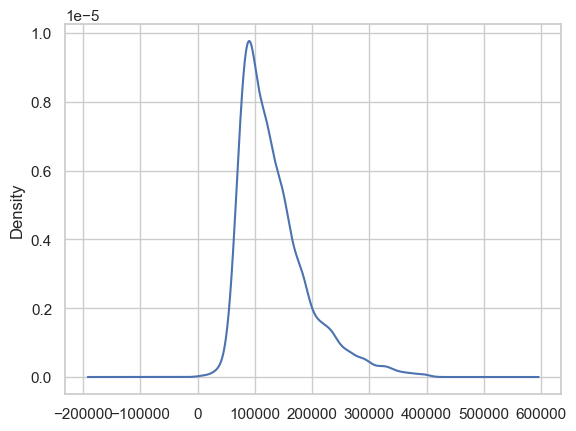

In [32]:
y.plot(kind='kde');

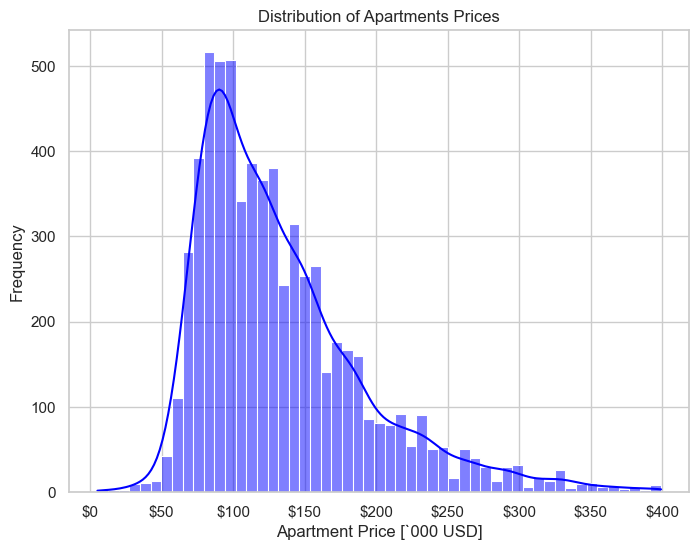

In [33]:
# Create a distribution plot using Seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.histplot(y, kde=True, color="blue")

# Adding labels and title
plt.xlabel("Apartment Price [`000 USD]")
plt.ylabel("Frequency")
plt.title("Distribution of Apartments Prices")

# Format x-axis labels to display prices in "$100,000" format
def price_formatter(x, pos):
    return f"${int(x/1000):,}"

ax = plt.gca()
ax.xaxis.set_major_formatter(mticker.FuncFormatter(price_formatter))

plt.show()

In [34]:
from sklearn.model_selection import train_test_split

# split into train (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Build Model**

## Baseline

In [35]:
y_mean = (y_train.mean())

y_pred_baseline = [y_mean]*len(y_train)
print("Mean apt price: $",round(y_mean, 2))

print("Baseline MAE: $", round(mean_absolute_error(y_train,y_pred_baseline),2))

Mean apt price: $ 133158.78
Baseline MAE: $ 44845.54


## Iterate

In [36]:
model_lr = make_pipeline(

    OneHotEncoder(use_cat_names=True), # encode cat features
    SimpleImputer(), # imputation
    LinearRegression()) # build model

# fit the model
model_lr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression())])

## Evaluate

In [37]:
# Predict the train data
y_pred_training = model_lr.predict(X_train)
y_pred_test = model_lr.predict(X_test)

# Compute MAE
print("Training MAE:", round(mean_absolute_error(y_train, y_pred_training),2))
print("Test data MAE:", round(mean_absolute_error(y_test, y_pred_test),2))

Training MAE: 24215.29
Test data MAE: 25303.61


The metric values above shows higher `MAE` on test data than on training data, which is clear sign of a possibility of overfitting to the training set, which means its performing well on the training set but not on the test set. Regularization techniques maybe used to prevent overfitting, which can result to higher MAE on the training set but lower MAE on the test set.

In this case, cross-validation will be used instead of regularization.

__Task:__ Try Ridge Regression for regularization.

## Cross-Validation

We train our model using `RandomForest` and perform cross-validation for hyper-parameter tuning of our model. __Cross-validation__ helps you find the optimal hyperparameters for your model by evaluating its performance under different settings. This ensures the model is robust, generalizes well, and performs well on new data.

In [38]:
rf = make_pipeline(

    # encode cat features
    OneHotEncoder(use_cat_names=True),

    # Imputation
    SimpleImputer(),

    # build model
    RandomForestRegressor(
        random_state=42)
    )

# fit the model
rf.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['neighborhood'], use_cat_names=True)),
                ('simpleimputer', SimpleImputer()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [39]:
# Predict the train data
y_pred_training = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# Compute MAE
print(f"Training MAE:${round(mean_absolute_error(y_train, y_pred_training),2)}")
print(f"Test data MAE:${round(mean_absolute_error(y_test, y_pred_test),2)}")

Training MAE:$7946.77
Test data MAE:$20839.89


In [40]:
# For Cross-validation
from sklearn.model_selection import GridSearchCV, cross_val_score

In [41]:
# Define hyper-parameters
params = {
    "randomforestregressor__n_estimators": range(25, 100, 25),
    "randomforestregressor__max_depth": range(10, 50, 10)
}
params

{'randomforestregressor__n_estimators': range(25, 100, 25),
 'randomforestregressor__max_depth': range(10, 50, 10)}

In [42]:
# max_depth
[i for i in range(10, 50, 10)]

[10, 20, 30, 40]

In [43]:
# n_estimators
[j for j in range(25, 100, 25)]

[25, 50, 75]

In [44]:
model = GridSearchCV(
    rf,
    param_grid=params,
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the model
model.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('onehotencoder',
                                        OneHotEncoder(cols=['neighborhood'],
                                                      use_cat_names=True)),
                                       ('simpleimputer', SimpleImputer()),
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': range(10, 50, 10),
                         'randomforestregressor__n_estimators': range(25, 100, 25)},
             verbose=1)

In [45]:
cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1)
cv_results = pd.DataFrame(model.cv_results_)
model.best_params_

{'randomforestregressor__max_depth': 30,
 'randomforestregressor__n_estimators': 75}

In [46]:
# Predict the train data
y_pred_training = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Compute MAE
print("Training MAE:", round(mean_absolute_error(y_train, y_pred_training),2))
print("Test data MAE:", round(mean_absolute_error(y_test, y_pred_test),2))

Training MAE: 8008.15
Test data MAE: 20799.07


## Save Work

In [47]:
import joblib
# Save Model
joblib.dump(model, 'artifacts/hse_prediction_model.pkl')

# Loading Model
model = joblib.load('artifacts/hse_prediction_model.pkl')

# Make predictions
model.predict(X)

array([135331.46666667,  87903.48011111, 119800.        , ...,
        72601.16444444,  93282.79024541,  90089.66727385])

# **Communicate Results**

### Feature Importance

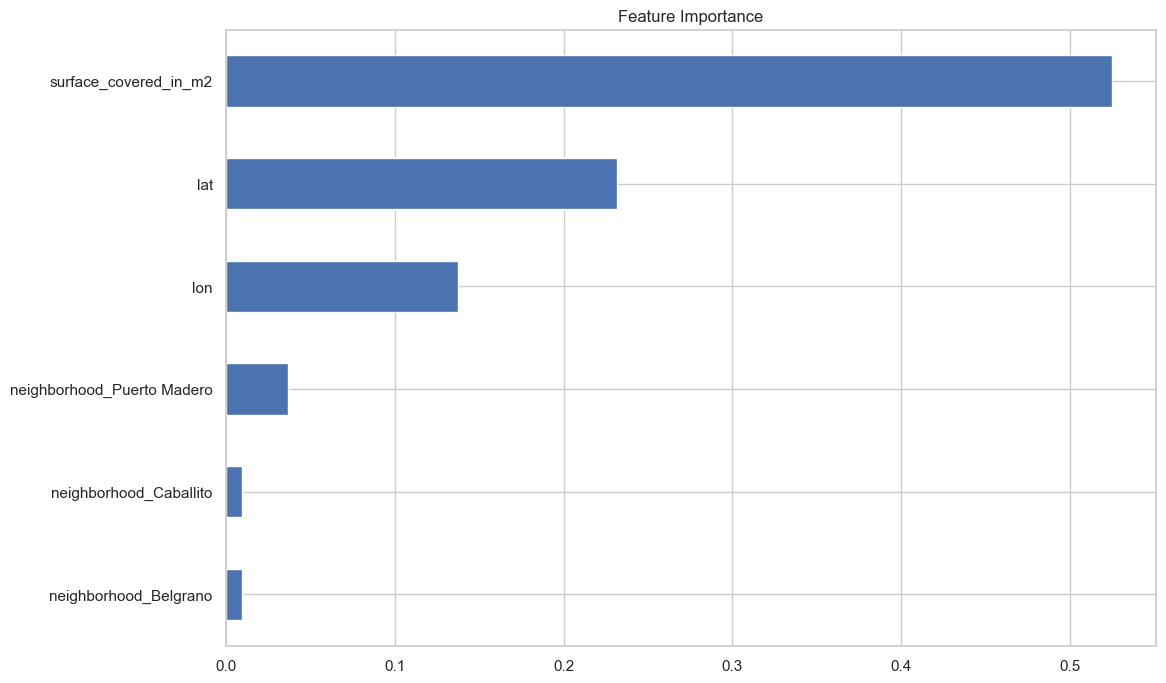

In [48]:
# Get coefficients of features
coefficients = rf.named_steps.randomforestregressor.feature_importances_

# Get feature names
features = rf.named_steps["onehotencoder"].get_feature_names()

# Create a Series of features
feat_imp = pd.Series(data=coefficients, index=features)

plot_feat_imp = feat_imp.sort_values(ascending=True).tail(6)
plot_feat_imp.plot(kind="barh", figsize=(12,8))
plt.title("Feature Importance")
plt.show()

In [49]:
def make_prediction(area, lat, lon, neighborhood):

    # Load the model
#     model = joblib.load(model_name)

    # Creating a dictionary for the new data
    data = {
        "lat": lat,
        "lon": lon,
        "surface_covered_in_m2": area,
        "neighborhood": neighborhood
    }

    # Create a DataFrame
    df = pd.DataFrame(data, index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted apartment price: ${prediction:.2f}"

In [50]:
make_prediction(-34.60, -38.46, 110, "Saavedra")

'Predicted apartment price: $65114.81'

In [51]:
interact(

    # Predicting an output (apartment price)
    make_prediction,
# Area input
    area=IntSlider(
        min=X_train["surface_covered_in_m2"].min(),
        max=X_train["surface_covered_in_m2"].max(),
        value=X_train["surface_covered_in_m2"].mean(),
        ),
# Latitude input
    lat=FloatSlider(
        min=X_train["lat"].min(),
        max=X_train["lat"].max(),
        step=0.01,
        value=X_train["lat"].mean(),
        ),
# Longitude input
    lon=FloatSlider(
        min=X_train["lon"].min(),
        max=X_train["lon"].max(),
        step=0.01,
        value=X_train["lon"].mean(),
        ),
# Neighborhood input
    neighborhood=Dropdown(
        options=sorted(X_train["neighborhood"].unique()),
        value="Boca"
        ),
    );

interactive(children=(IntSlider(value=53, description='area', min=31), FloatSlider(value=-34.59884160795521, d…